In [1]:
# Standard:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Prophet Package +:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_from_dict, model_to_dict, model_from_json, model_to_json, SIMPLE_ATTRIBUTES

# Hyperopt:
from hyperopt import fmin, tpe, hp, anneal, Trials, SparkTrials, STATUS_OK, space_eval

# Definitions:
granularity = "D"
category = "Non-domestic"

# Paths:
demand_path = "../../data/gross_demand_daily.parquet"
h_weather_path = "../../data/gb_historic_hourly_weather.parquet"
h_average_weather_path = "../../data/gb_average_hourly_weather.parquet"
d_weather_path = "../../data/gb_historic_daily_weather.parquet"
d_average_weather_path = "../../data/gb_average_daily_weather.parquet"

# Default parameters for scoring models:
daily_cross_val_horizon = '366 days'
daily_initial = '2190 days'
daily_period = '180 days'


In [2]:
# Demand DataFrame

df = pd.read_parquet(demand_path).rename(columns={'settlement_date' : 'date'})
df = df.groupby(by=['date', 'sector'])[['total_corrected_consumption_gwh']].sum().reset_index()
df = df[ (df['sector'] == category)].rename(columns={
'total_corrected_consumption_gwh': 'y',
'date': 'ds'}).reset_index(drop=True).sort_values('ds')
initial_date = df['ds'].min()
final_date = df['ds'].max()
initial_year = initial_date.year
final_year = final_date.year

df.head()

,ds,sector,y
0,2015-01-01,Non-domestic,391.343216
1,2015-01-02,Non-domestic,466.612301
2,2015-01-03,Non-domestic,465.952047
3,2015-01-04,Non-domestic,444.566305
4,2015-01-05,Non-domestic,589.207401


In [3]:
# Regressors DataFrame

weekend = pd.DataFrame({'ds' : pd.date_range(start=initial_date, end=datetime.date(2051,3,31), freq='D')})
weekend['sat_reg'] = weekend['ds'].apply(lambda x: np.abs(x.timetuple().tm_yday - 182.6) if x.weekday() == 5 else 0)
weekend['sun_reg'] = weekend['ds'].apply(lambda x: np.abs(x.timetuple().tm_yday - 182.6) if x.weekday() == 6 else 0)

temp = pd.read_parquet(h_weather_path)
temp = temp[temp['date'] < temp['date'].max()]
temp.columns = temp.columns.str.replace('gb_','')
temp = temp.rename(columns={'date':'ds'})
temp = temp.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()

future_temp = pd.read_parquet(h_average_weather_path)
future_temp.columns = future_temp.columns.str.replace('gb_','')
future_temp = future_temp.rename(columns={'date':'ds'})
future_temp = future_temp.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()
future_temp = future_temp[future_temp['ds'] > temp['ds'].max()]
future_temp = pd.concat([temp, future_temp]).reset_index(drop=True)

average_temp_all = pd.read_parquet(h_average_weather_path)
average_temp_all.columns = average_temp_all.columns.str.replace('gb_','')
average_temp_all = average_temp_all.rename(columns={'date':'ds'})
average_temp_all = average_temp_all.groupby('ds').agg(
  {'temperature' : 'mean',
  'hdd' : 'sum',
  'cdd' : 'sum'}).reset_index()

temp.head()

,ds,temperature,hdd,cdd
0,2015-01-01,9.994652,803.921260,0.0
1,2015-01-02,6.967103,1949.742425,0.0
2,2015-01-03,4.495221,2882.854784,0.0
3,2015-01-04,1.930792,3866.575854,0.0
4,2015-01-05,6.817229,1990.184090,0.0


In [4]:
# Extra Seasonality DataFrame

seasonality = pd.DataFrame({'ds' : pd.date_range(start=initial_date, end=datetime.date(2051,3,31), freq='D')})
seasonality['weekly_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2021-03-21')))
seasonality['yearly_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2022-02-20')))
seasonality['weekly_post_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2021-03-21')) & (pd.to_datetime(seasonality['ds']) < pd.to_datetime('2022-02-20')))
seasonality['weekly_new_normal'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2022-02-20')))
seasonality['yearly_post_covid_addition'] = ((pd.to_datetime(seasonality['ds']) >= pd.to_datetime('2022-02-20')))

seasonality.head()

,ds,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,False,False,False,False,False
1,2015-01-02,False,False,False,False,False
2,2015-01-03,False,False,False,False,False
3,2015-01-04,False,False,False,False,False
4,2015-01-05,False,False,False,False,False


In [5]:
# Merging Demand df with Regressors, Seasonality, etc.

df = df.merge(temp, how='inner', on='ds').merge(weekend, how='inner', on='ds').merge(seasonality, how='inner', on='ds')

In [6]:
# Future df

future_df = pd.DataFrame({'ds': pd.date_range(start=initial_date, end=final_date + datetime.timedelta(days=30), freq='D')})
future_df['sector'] = category
future_df = future_df.merge(future_temp, how='left', on='ds').merge(weekend, how='inner', on='ds').merge(seasonality, how='left', on='ds')
future_df.head()

,ds,sector,temperature,hdd,cdd,sat_reg,sun_reg,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,Non-domestic,9.994652,803.921260,0.0,0.0,0.0,False,False,False,False,False
1,2015-01-02,Non-domestic,6.967103,1949.742425,0.0,0.0,0.0,False,False,False,False,False
2,2015-01-03,Non-domestic,4.495221,2882.854784,0.0,179.6,0.0,False,False,False,False,False
3,2015-01-04,Non-domestic,1.930792,3866.575854,0.0,0.0,178.6,False,False,False,False,False
4,2015-01-05,Non-domestic,6.817229,1990.184090,0.0,0.0,0.0,False,False,False,False,False


In [7]:
# Creating Holidays df

holidays_dic = {
1 : 'dow12',
2 : 'dow12',
3 : 'dow34',
4 : 'dow34',
5 : 'dow5',
6 : 'dow6',
7 : 'dow7'}

year_list = list(range(2015,2024+1))
holidays = make_holidays_df(year_list=year_list, country='UK')

# Dropping Norther Ireland's holidays & Christmas Holidays as these will be added depending on the day-of-week
northern_ireland = ["St. Patrick's Day [Northern Ireland]", "Battle of the Boyne [Northern Ireland]", "St. Patrick's Day [Northern Ireland] (Observed)"]
holidays = holidays[~holidays['holiday'].isin(northern_ireland)]
drop_xmas_ny = ['Boxing Day', 'Boxing Day (Observed)', 'Christmas Day', 'New Year Holiday [Scotland]', "New Year's Day"]
holidays = holidays[~holidays['holiday'].isin(drop_xmas_ny)]
holidays['lower_window'] = -1
holidays['upper_window'] = 1

# Lockdowns + Beast of the East as one-off holiday
lockdowns = pd.DataFrame([
  {'holiday': 'beast_of_the_east', 'ds': '2018-02-24', 'lower_window': 0, 'ds_upper': '2018-04-19'},
  {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-30'},
  {'holiday': 'lockdown_2', 'ds': '2020-10-25', 'lower_window': 0, 'ds_upper': '2020-12-15'},
  {'holiday': 'lockdown_3', 'ds': '2021-02-15', 'lower_window': 0, 'ds_upper': '2021-03-12'}])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns = lockdowns.drop(columns='ds_upper')

## Christmas Holidays depending on the day-of-week
add_xmas_ny = ["12_22", "12_23", "12_24", "12_25", "12_26", "12_27", "12_28", "12_29", "12_30", "12_31", "1_1", "1_2"]
extra_holidays = pd.DataFrame({'ds':pd.date_range(start='2015-01-01', end='2050-12-31')})
extra_holidays['month_day'] = extra_holidays['ds'].dt.month.astype(str) + '_' + extra_holidays['ds'].dt.day.astype(str)
extra_holidays = extra_holidays[extra_holidays['month_day'].isin(add_xmas_ny)]
extra_holidays['group'] = extra_holidays['ds'].dt.dayofweek + 1
extra_holidays['group'] = extra_holidays['group'].map(holidays_dic)
extra_holidays.loc[:,'holiday'] = 'xmas_ny_' + extra_holidays.loc[:,'month_day'] + '_' + extra_holidays.loc[:,'group'] 
extra_holidays = extra_holidays.drop(columns=['month_day', 'group'])
extra_holidays['lower_window'] = 0
extra_holidays['upper_window'] = 0

## Merging the DataFrames
holidays = pd.concat([holidays,lockdowns]).reset_index(drop=True)
holidays = pd.concat([holidays,extra_holidays]).reset_index(drop=True)
holidays = holidays.sort_values('ds')
holidays['holiday'] = holidays['holiday'].str.lower()
holidays['holiday'] = holidays['holiday'].str.replace(" ","_", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("'","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace(".","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("/","_", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("(","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace(")","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("[","", regex=False)
holidays['holiday'] = holidays['holiday'].str.replace("]","", regex=False)  

In [8]:
# Forecasting Timeseries - Creating needed variables for optimisation.

model = Prophet( # Default values
  growth = 'linear',
  seasonality_mode = 'multiplicative',
  holidays_mode = 'multiplicative',
  changepoints=None,
  n_changepoints=25,
  changepoint_range=0.8,
  holidays=holidays,
  seasonality_prior_scale=10.0,
  holidays_prior_scale=10.0,
  changepoint_prior_scale=0.05,
  mcmc_samples=0,
  interval_width=0.80,
  uncertainty_samples=1000,
  yearly_seasonality = True,
  weekly_seasonality = True,
  daily_seasonality = False
)

for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
  model.add_regressor(reg,
                      mode='multiplicative')

for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
  model.add_seasonality(name=name,
                        period=period,
                        fourier_order=fourier_order,
                        condition_name=name)

In [9]:
# HyperOpt:

daily_base_tuning = ['changepoint_prior_scale', 'seasonality_prior_scale', 'holidays_prior_scale', 'changepoint_range']

daily_base_hyperopt = {
  'changepoint_prior_scale' : (0.01, 0.05),
  'seasonality_prior_scale': (5, 30),
  'holidays_prior_scale': (5, 30),
  'changepoint_range': (0.99, 1)}

daily_regressors_hyperopt = {
  'temperature' : (5, 30),
  'hdd' : (5, 30),
  'cdd' : (5, 30),
  'sat_reg' : (5, 30),
  'sun_reg' : (5, 30)}

space = {}
space_dict = {}

# Creating the HyperOpt Space for the tuning [We could use log instead of uniform?]
for item in daily_base_tuning:
  space[item] = hp.uniform(item, daily_base_hyperopt[item][0], daily_base_hyperopt[item][1])
  space_dict[item] = ('hp.uniform', daily_base_hyperopt[item][0], daily_base_hyperopt[item][1])

for item in [i for i in model.extra_regressors]:
  space[item] = hp.uniform(item, daily_regressors_hyperopt[item][0], daily_regressors_hyperopt[item][1])
  space_dict[item] = ('hp.uniform', daily_regressors_hyperopt[item][0], daily_regressors_hyperopt[item][1])

# HyperOpt algorithm and +
algo = tpe.suggest
max_evals = 1
trials = Trials()
rstate = np.random.default_rng(42)

In [10]:
def hyperopt_tuning(hyperopt):

  global model

  # Creating the forecasting model with the variables we are using: multiplicative, holidays, regressors, seasonalities.
  model = Prophet( # Default values
  growth = 'linear',
  seasonality_mode = 'multiplicative',
  holidays_mode = 'multiplicative',
  changepoints=None,
  n_changepoints=25,
  changepoint_range=0.8,
  holidays=holidays,
  seasonality_prior_scale=10.0,
  holidays_prior_scale=10.0,
  changepoint_prior_scale=0.05,
  mcmc_samples=0,
  interval_width=0.80,
  uncertainty_samples=1000,
  yearly_seasonality = True,
  weekly_seasonality = True,
  daily_seasonality = False
)

  for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
    model.add_regressor(reg,
                        mode='multiplicative')

  for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
    model.add_seasonality(name=name,
                          period=period,
                          fourier_order=fourier_order,
                          condition_name=name)

  # Using Hyperopt to tune the base hyperparams: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range.
  for hyperparam in daily_base_tuning:
    setattr(model, hyperparam, hyperopt[hyperparam])

  # Using Hyperopt to tune the extra hyperparams: regressors unique to the model.
  for regressor_hyperparam in [i for i in model.extra_regressors]:
    model.extra_regressors[regressor_hyperparam]['prior_scale'] = hyperopt[regressor_hyperparam]

  # For the extra seasonalities:
  for season in ['weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']:
    model.seasonalities[season]['prior_scale'] = hyperopt['seasonality_prior_scale']

  # Fitting the model with the hyperopt variables to optimize them using the aglorithm "Tree of Parzen Estimators" by default. This can be changed.
  model.fit(df)

  # Scoring parameters for each iteration in the optimization.
  df_cv = cross_validation(model, initial=daily_initial, period=daily_period, horizon=daily_cross_val_horizon)
  df_p = performance_metrics(df_cv, rolling_window=1)
  df_p['cutoff_points'] = len(df_cv['cutoff'].unique())
  score = df_p['mape'].values[0]

  return {
  'loss' : score,
  'status' : STATUS_OK,
  'cutoff_points' : df_p['cutoff_points'][0], 
  'horizon_days' : df_p['horizon'][0].days,
  'prophet_dict' : model_to_dict(model),
  'hopt_algorithm' : algo.__module__,
  'max_iters' : max_evals,
  'random_state' : rstate
  } 

In [11]:
hyperopt_optimization = fmin(fn=hyperopt_tuning,
                              space = space,
                              algo= algo,
                              max_evals=max_evals,
                              trials= trials,
                              rstate= rstate)


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

13:39:36 - cmdstanpy - INFO - Chain [1] start processing

13:39:41 - cmdstanpy - INFO - Chain [1] done processing



  0%|          | 0/4 [00:00<?, ?it/s]

13:39:41 - cmdstanpy - INFO - Chain [1] start processing

13:39:42 - cmdstanpy - INFO - Chain [1] done processing

13:39:43 - cmdstanpy - INFO - Chain [1] start processing

13:39:44 - cmdstanpy - INFO - Chain [1] done processing

13:39:45 - cmdstanpy - INFO - Chain [1] start processing

13:39:46 - cmdstanpy - INFO - Chain [1] done processing

13:39:47 - cmdstanpy - INFO - Chain [1] start processing

13:39:49 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 1/1 [00:12<00:00, 12.86s/trial, best loss: 0.17656065211147282]


In [12]:
best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)

print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


[1, 1, 1, 25, 1, 421, 3134]

/Users/pabloparedes/pablo/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/pabloparedes/pablo/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/pabloparedes/pablo/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

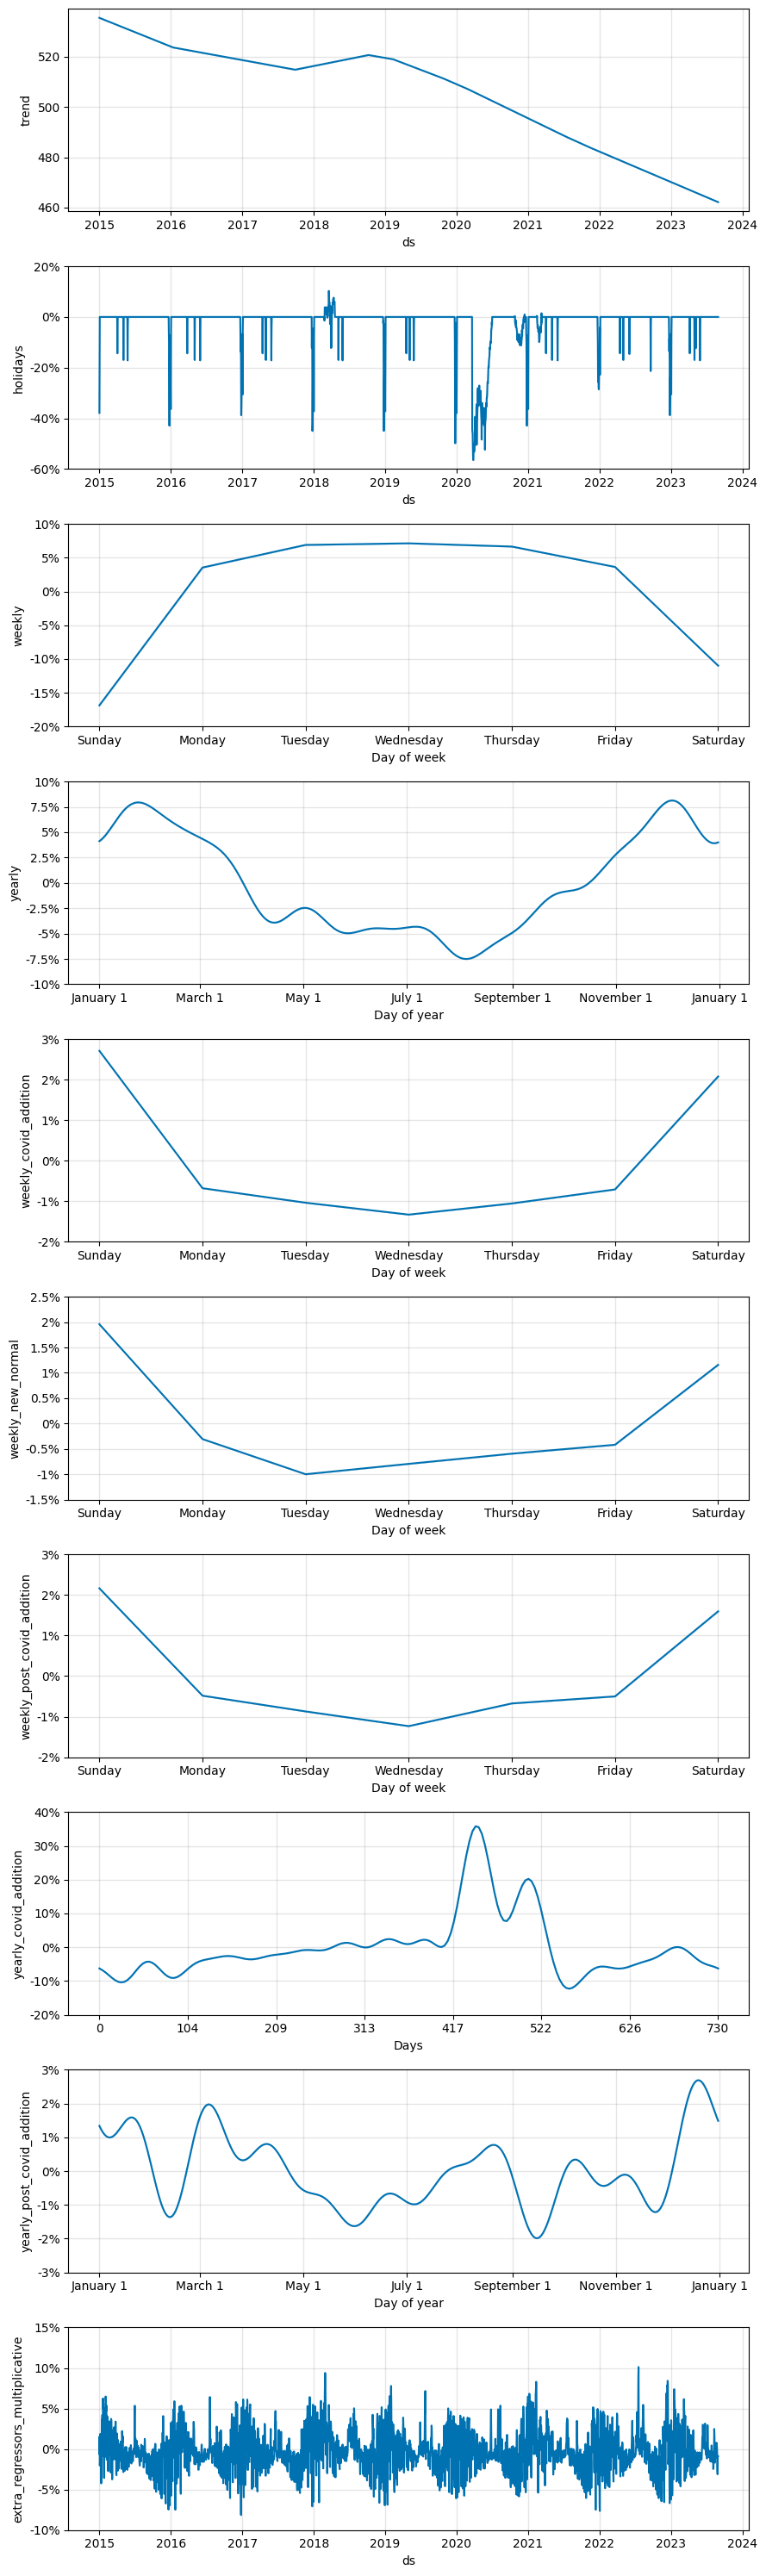

/Users/pabloparedes/pablo/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/pabloparedes/pablo/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


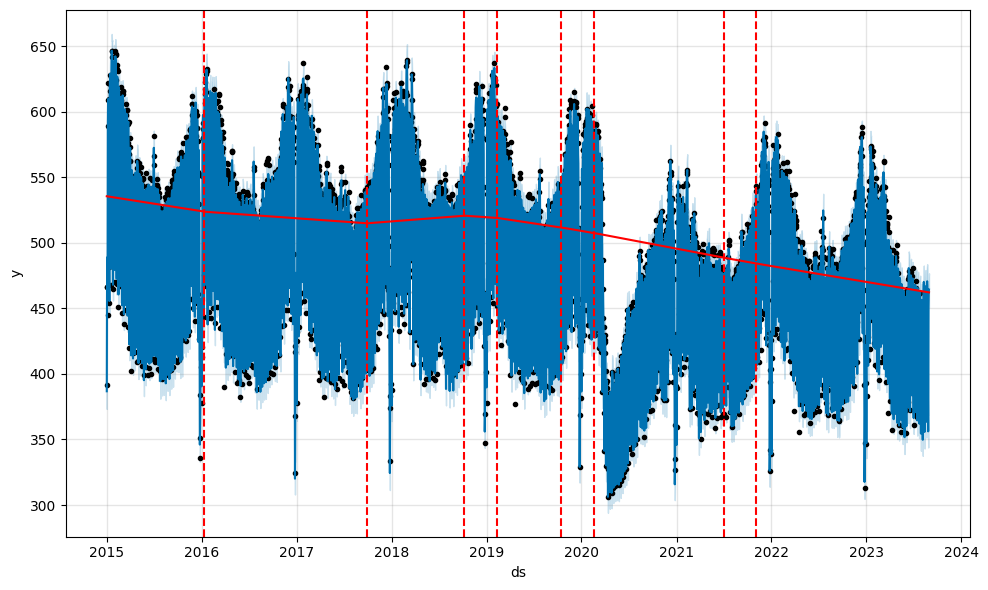

In [13]:
fig = best_model.plot_components(forecast)
plt.show()

fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)
plt.show()

In [14]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,beast_of_the_east,beast_of_the_east_lower,beast_of_the_east_upper,boxing_day_observed,...,yearly_covid_addition,yearly_covid_addition_lower,yearly_covid_addition_upper,yearly_post_covid_addition,yearly_post_covid_addition_lower,yearly_post_covid_addition_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,535.482239,373.263219,398.271999,535.482239,535.482239,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,386.743853
1,2015-01-02,535.450873,454.903266,478.526095,535.450873,535.450873,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,466.558652
2,2015-01-03,535.419507,476.274000,500.972977,535.419507,535.419507,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,488.897751
3,2015-01-04,535.388142,447.830574,472.738448,535.388142,535.388142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.255621
4,2015-01-05,535.356776,576.117847,599.541840,535.356776,535.356776,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.034917


In [15]:
print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

preprocess = best_model.preprocess(df)
# lp
# k
# m
# delta [preprocess S size]
# sigma_obs
# beta [preprocess K size]
# trend [preprocess T size]
# [preprocess X is size (T,K)]


['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


In [16]:
components = model.train_component_cols
# 1 for each coefficient
# There are 3 columns grouping holidays, regressors and all terms: holidays, extra_regressors_multiplicative, multiplicative_terms.
# Dropping them, the sum of 1s if beta [preprocess K size]
print(components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).sum().sum())
components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).T.sum(axis=1)

421


component
beast_of_the_east             55
boxing_day_observed            3
cdd                            1
christmas_day_observed         3
coronation_of_charles_iii      3
                              ..
xmas_ny_1_2_dow7               1
yearly                        20
yearly_covid_addition         30
yearly_post_covid_addition    20
additive_terms                 0
Length: 86, dtype: int64

In [17]:
regressor_coefficients(best_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temperature,multiplicative,10.551490,0.004016,0.004016,0.004016
1,hdd,multiplicative,1191.209680,0.000029,0.000029,0.000029
2,cdd,multiplicative,46.788950,0.000026,0.000026,0.000026
3,sat_reg,multiplicative,12.948309,-0.000297,-0.000297,-0.000297
4,sun_reg,multiplicative,12.940970,-0.000384,-0.000384,-0.000384


In [18]:
# coef * (variable - variable.mean())
# forecaster.py line 365
# df[name] = ((df[name] - props['mu']) / props['std']) 
# Centering the variable before fitting makes "positive" regressors go negative at times - this could be taken out.

print(best_model.extra_regressors['temperature'])
# It would be ('temperature' - 'mu')/'std'

{'prior_scale': 25.341385191007195, 'standardize': 'auto', 'mu': 10.551489714313586, 'std': 4.924583311691614, 'mode': 'multiplicative'}


**Regarding model.train_component_cols & more:**

- Prophet does a lot of data normalization prior to model fitting
- The y data that is giving in fit is scaled by its max value. Extra regressor columns are also by default standardized (that is, subtract mean, divide by sd) if non-binary.
- The coefficient value that you see will be one that is applied to the standardized values of the extra regressors, and then added to the scaled trend forecast.

**yhat(t) = trend(t) * (1 + seasonality(t) + beta * regressor(t))**

In [19]:
# All the inputs to stan:
transformed = best_model.preprocess(df)
# Paramteres of transformed:
[
  'K', # number of variables' coefficients [BETA size in model.params].
  'S', # number of slope changes (at each changepoint) [DELTA size in model.params].
  'T', # number of estimated values of the trend component of the time series at each time point. [TREND size in model.params].
  'X', # Dataframe of TxK (each time series point and the variables coefficients as columns).
  'cap', # for logistic growth.
  's_a', # additive terms.
  's_m', # multiplicative terms.
  'sigmas', # Coefficients' prior_scales (Hyperparameters)
  't', # time.
  't_change', # value of t at changepoints.
  'tau', # changepoint prior_scale >> flexibility.
  'trend_indicator',
  'y' # standardized y values.
  ]


# How the model parameters will be initialized:
print(best_model.calculate_initial_params(num_total_regressors=transformed.K))

ModelParams(k=0.08627336127373642, m=0.605497829985039, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [20]:
## Saving model:

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(best_model))  # Save model


In [21]:
## Reading model:

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
